In [20]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from collections import Counter
import matplotlib.pyplot as plt 
import glob
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import copy
from joblib import Parallel, delayed
import statsmodels.api as sm
import seaborn as sb
import multiprocessing
from tslearn.metrics import dtw

In [39]:
df_all = pd.read_csv('all_normalized.csv')
sses = []

def sse_finder(df, i):
    '''
    This function computes the SSE of the cluster
    df takes the dataframe
    i takes the number of clusters
    '''
    tskm_base = TimeSeriesKMeans(n_clusters = i, metric = "dtw", max_iter = 100, random_state = 27)
    #model
    tskm_base.fit(df.T.values)
    #compute SSE
    return tskm_base.inertia_



def opt_num_clust_finder(target_var):
    '''
    This function computes and plots the elbow method, which enabels to find the optimal number of clusters
    target_var takes the target variable you want to compute
    '''
    #cleaning the data
    df2 = df_all[['country_name', 'date', target_var]]
    df3 = df2.pivot(index='date', columns='country_name', values=target_var)
    df3 = df3['2020-03-01':'2021-12-01']
    df = df3.dropna(axis=1)
    
    #computing SSE of each region from each mean trends, varying the number of clusters
    sses = []
    pool_obj = multiprocessing.Pool()
    
    sses = Parallel(n_jobs=-1)(delayed(sse_finder)(df, i) for i in range(1, 11))

    #plot the elbow plot
    plt.plot(range(1, 11), sses, marker = 'o')
    plt.ylabel("SSE")
    plt.xlabel("Number of Clusters")
    plt.title("Optimal Number of Clusters for " + target_var)
    plt.savefig('opt_num_clusters_'+target_var+'.png')
    plt.show()

    
def clustering(target_var, cluster_count, top_n = 3):
    '''
    This function computes the actual clustering and returns the dictionary containing 
    the cluster labels associating with region names and error table showing which regions are the representative 
    for each cluster
    
    target_var takes the target variable you want to compute 
    cluster_count takes the number of clusters
    top_n controls the number of top n countires you want to see from the error table
    '''
    #cleaning the dataframe
    df2 = df_all[['country_name', 'date', target_var]]
    df3 = df2.pivot(index='date', columns='country_name', values=target_var)
    df3 = df3['2020-03-01':'2021-12-01']
    df = df3.dropna(axis=1)
    mySeries = df.T.values
    
    #running the time series clustering with Dynamic Time Wrapping method
    km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw",  max_iter = 100, random_state = 27)
    labels = km.fit_predict(mySeries)

    #visualizing the plots
    plot_count = math.ceil(math.sqrt(cluster_count))

    fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    
    # For each label there is,
    # plots every series with that label
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
                if(labels[i]==label):
                    axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                    cluster.append(mySeries[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
        axs[row_i, column_j].set_title("Cluster "+str(label))
        column_j+=1
        if column_j%plot_count == 0:
            row_i+=1
            column_j=0
            
    #saving the plot
    plt.savefig('Clusters_covid_cases' + target_var + '.png')
    plt.show()
     
    #compute the error table
            
    cluster_kv_base = pd.DataFrame(labels, columns=['cluster'])
    plot_temp_all = pd.DataFrame()          
    for i in range(cluster_count):
        cluster_kv_values_base = cluster_kv_base[cluster_kv_base['cluster'] == i].index.values.tolist()
        plot_temp = pd.DataFrame(df.iloc[:,cluster_kv_values_base].mean(axis=1))
        plot_temp.columns = ['cluster : ' + str(i)]
        plot_temp_all = pd.concat([plot_temp_all, plot_temp], axis=1)

    mean_df = plot_temp_all.iloc[:, 0:cluster_count]
    
    countries = df.columns
    df_diff = copy.deepcopy(df)
    dic = dict(zip(countries, km.labels_))

    for country in countries:
        df_diff.loc[:, country] = dtw(df.loc[:, country], mean_df.iloc[:, dic[country]])

    err = df_diff.sum(axis = 0)
    clusters = pd.Series(km.labels_, index = countries)
    err_df = pd.concat([clusters, err], axis=1)
    err_df.columns = ['cluster', 'Err']
    err_group = err_df.groupby('cluster')['Err'].nsmallest(top_n)

    return dic, err_group

### Be careful to run the code below because it takes almost one hour to run the elbow method for the all target variables.

In [ ]:
target_vars = [# 'stringency_index_x', 
#                  'government_response_index', 
#                  'containment_health_index', 
#                  'economic_support_index', 
                 'c1_school_closing',
                 'c2_workplace_closing',
                 'c3_cancel_public_events',
                 'c4_restrictions_on_gatherings',
                 'c5_close_public_transport',
                 'c6_stay_at_home_requirements',
                 'c7_movementrestrictions',
                 'c8_internationaltravel',
                 'e1_income_support',
                 'e2_debtrelief',
                 'h1_public_information_campaigns',
                 'h2_testing_policy',
                 'h3_contact_tracing',
                 'h6_facial_coverings',
                 'h7_vaccination_policy',
                 'h8_protection_of_elderly_people',
                 'new_cases_smoothed_per_million']


for target_var in target_vars[:1]:
    opt_num_clust_finder(target_var)

# Example

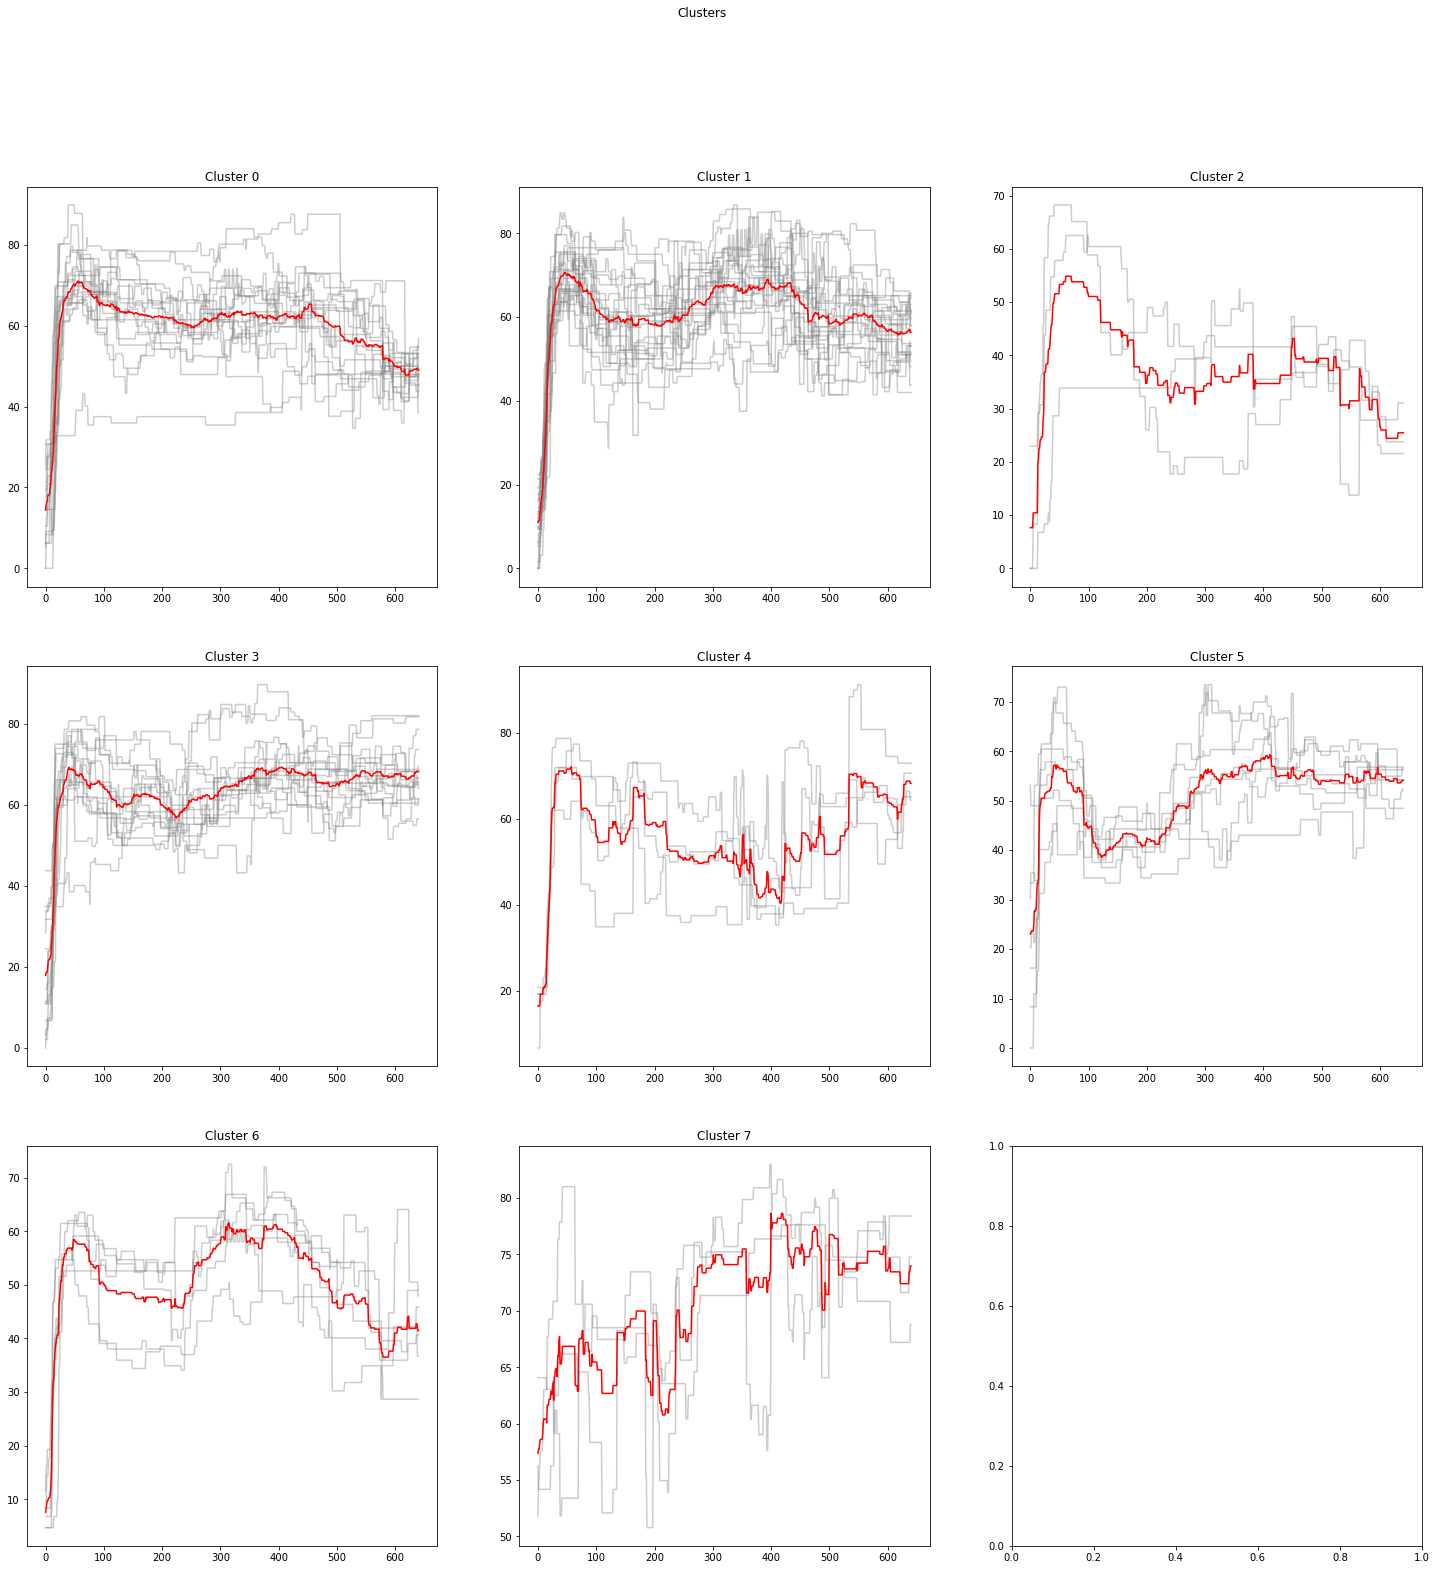

In [43]:
dic1, error_df = clustering(target_var = 'government_response_index', cluster_count = 8)

In [46]:
# These optimal number of clusters are determined subjectively,
#meaning we check the elbeow graphs and decide the optimal number of clusters
opt_num_clus = [7,3, 3, 6, 5, 6, 4, 2, 4, 2, 4, 2, 2, 4, 5, 4, 4]

In [ ]:
# This will produce a huge list of dictionary containing the all information of clustering labels for every individual policy
dic_l = []
for i in range(len(target_vars)):
    dic1 = clustering(target_var = target_vars[i], cluster_count = opt_num_clus[i])
    dic_l.append(dic1)

# references
- Amidon, A., 2020. “How to Apply K-means Clustering to Time Series Data.” Towards Data Science. Retrieved Feb 15, 2022 (https://towardsdatascience.com/how-to-apply-k-means-clustering-to-time-series-data-28d04a8f7da3)